# More complex approaches

In this notebook we first make some prepartions of the data that is now stored in a file 'train_data.csv' (since it takes a long time to compute it), make principal component analysis on segment road information dataset. Next we try: to make autoregression on the crashes data as time series (3 variables: 2 coodinates of the crash and time passed since the previous accident) to learn to predict next accident based on some number of previous ones and to solve classification problem of predicting the number of crashes based on the weather conditions and the road segment properties. 

In [155]:
import pandas as pd
import geopandas as gpd # For loading the map of road segments

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline

# The Challenge

The main dataset for this challenge (in Train.csv) is a record of crashes within Nairobi over 2018-19. Each crash has an associated datetime and location. Let's load the data and take a look.

In [157]:
# Load the data
df = pd.read_csv('Data/Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


<AxesSubplot:title={'center':'Crash Locations'}, xlabel='longitude', ylabel='latitude'>

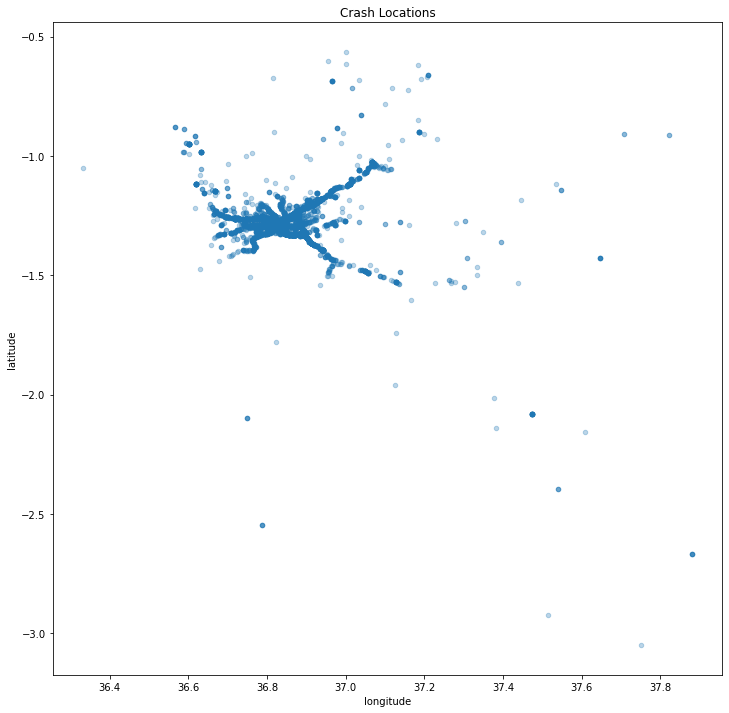

In [158]:
# Plot the crashes

df.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

In [159]:
df['Date'] = pd.to_datetime(df['datetime'])

Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled. 

This is of course a simplification of the problem, but by solving this you will hopefully develop strategies that can be used going forward.

In [160]:
# View the submission format
ss = pd.read_csv('Data/SampleSubmission.csv', parse_dates=['date'])
ss.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-07-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-07-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-07-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0


# Scoring

You can re-create the scoring process by creating your own test set and using the following function:

In [161]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

In [162]:
# Example:

# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = 0
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:
sub['A'+str(ambulance)+'_Latitude'] = 36.82
sub['A'+str(ambulance)+'_Longitude'] = -1.3



score(sub, reference)

70886.38526378157

This scoring function can be used for local testing without needing to submit on Zindi. Lower is better. Experiment with specifying set locations for all 6 ambulances, and see how low you can get your score.

# Weather Data

Some weatehr variables form the GFS dataset are provided, covering the greater Nairobi area. Let's take a quick look at the dataset before moving on:

In [163]:
weather = pd.read_csv('Data/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather['Date'] = pd.to_datetime(weather['Date'].dt.date)
weather.head()

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742


# Road Survey Data

The road survey data contains many different measurements for each surveyed road segment. Unfortunately we can't access the raw data, and must work 'in the dark' in terms of what the column headings mean. However, the naming convention does at least show which columns may be related.

To locate the road segments geographically, a geojson file is provided. Here is an example of merging the survey data with the segments and visualizing the result.

In [164]:
# Load the survey data
road_surveys = pd.read_csv('Data/Segment_info.csv')
road_surveys.head()

,segment_id,side,25_48,79_76,79_65,79_39,28_78_50,55_90,26_76,92_30,...,80_97_61_65_11,80_97_61_65_12,80_97_61_65_15,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16
0,176_2,1,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,176_2,2,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,95_1,1,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,95_1,2,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144_7,1,1,0,4,3,0.0,5,0,3,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [165]:
# Load the map
road_segment_locs = gpd.read_file('Data/segments_geometry.geojson')
road_segment_locs.head()

,segment_id,road_name,geometry
0,28_1,accra road-tertiary,"LINESTRING (36.82603 -1.28447, 36.82605 -1.284..."
1,137_1,accra road-tertiary,"LINESTRING (36.82656 -1.28371, 36.82658 -1.283..."
2,137_2,accra road-tertiary,"LINESTRING (36.82711 -1.28289, 36.82713 -1.282..."
3,1_1,airport north road-primary,"LINESTRING (36.88646 -1.33284, 36.88649 -1.332..."
4,1_2,airport north road-primary,"LINESTRING (36.88726 -1.33226, 36.88729 -1.332..."


<AxesSubplot:>

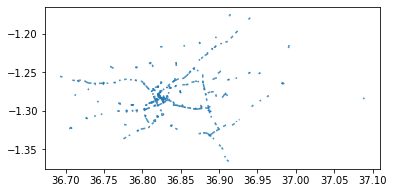

In [166]:
# Because this is a geodataframe, we can plot it
road_segment_locs.plot()

<AxesSubplot:>

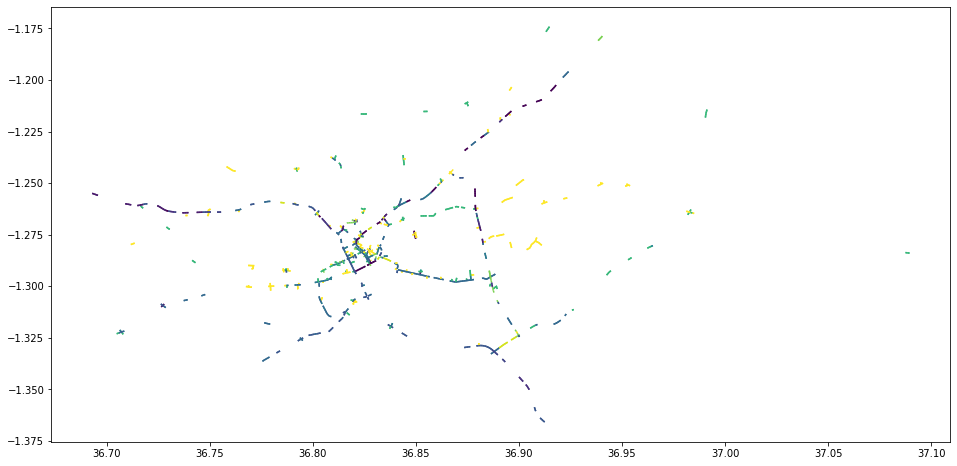

In [167]:
# Let's merge the two and color by one of the survey columns
segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
segments_merged.plot(column='55_90', figsize=(20, 8))

<AxesSubplot:>

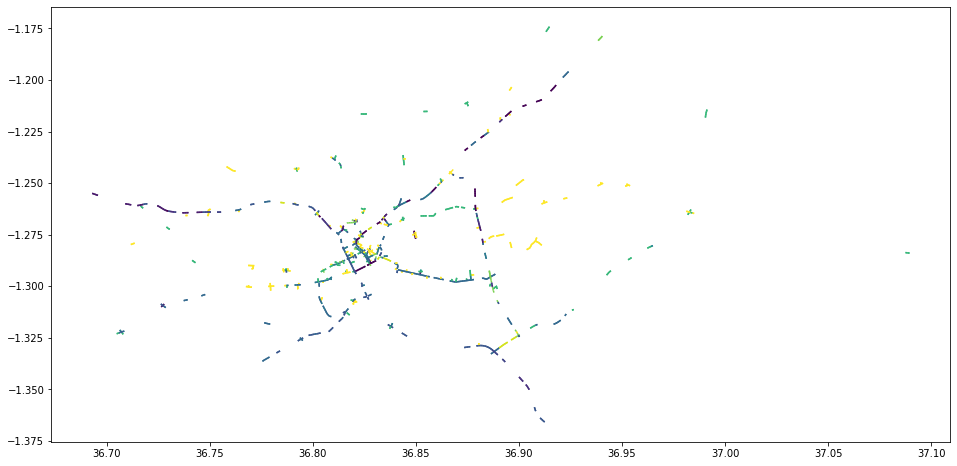

In [168]:
segments_merged.plot(column='55_90', figsize=(20, 8))

Let's see if segment geometry is comparable with the scale of our task. 

In [169]:
from shapely.geometry import LineString, shape
import numpy as np

segments_merged['geometry'] = segments_merged['geometry'].apply(lambda x: np.array(list(shape(x).coords)))
segments_merged['geometry'].apply(lambda x: np.std(x[:, 0])).max()

/home/adalnhard/.local/lib/python3.6/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


0.0005350749622266016

We can see that the length of the biggest road segment is almost 1000 times smaller than the scale of the roadmap. So it's reasonable to store just a mean instead of all the dots in segment geometry. 

In [170]:
segments_merged['geometry'] = segments_merged['geometry'].apply(lambda x: (np.mean(x[:, 0]),
                                                                           np.mean(x[:, 1])))

In [171]:
segments_merged['geometry'].describe()

count                                         1535
unique                                         792
top       (36.82244548416984, -1.2825037058498687)
freq                                             2
Name: geometry, dtype: object

In the following cell we added the geometrically nearest road segment to each crash observation. I commented it, because it takes a lot of time to compute. 

In [172]:
#from scipy.spatial.distance import euclidean as edist
#from tqdm.notebook import tqdm

#df['segment_id'] = df[['longitude', 'latitude']].apply(lambda x: (x[0], x[1]), axis=1)
#for i in tqdm(range(df.shape[0])):
#    crash_coords = df.iloc[i]['segment_id']
#    min_dist = 100
#    segment_id = 0
#    for j in range(road_segment_locs.shape[0]):
#        dots = np.array(list(shape(road_segment_locs.iloc[j]['geometry']).coords))
#        distances = [edist(crash_coords, x) for x in dots]
#        if min(distances) < min_dist:
#            min_dist = min(distances)
#            segment_id = road_segment_locs.iloc[j]['segment_id']
#    df.loc[df.uid == i+1, 'segment_id'] = segment_id

In [173]:
#df.to_csv('preprocessed_df.csv', index=False)

# PCA and TNSE on road survey data

In [174]:
#fill NaN's with mean over the column
for name, column in road_surveys.iteritems():
    road_surveys[name] = road_surveys[name].fillna(column.mean())

Here we can't just drop columns containing Nan's because all accesible information about road segments is needed. And since we don't know the origin of the data, it's reasonable to fill Nan's with the mean over the column.

In [175]:
gp = road_surveys.groupby('segment_id', as_index=False).mean()
gp.drop('side', axis=1, inplace=True)

In [176]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(gp.drop(['segment_id'], axis=1))
gp_scaled = scaler.transform(gp.drop(['segment_id'], axis=1))
pca = PCA()
coordinates_pca = pca.fit_transform(gp_scaled)

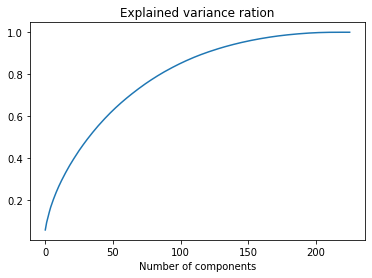

In [177]:
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.title('Explained variance ration')
plt.xlabel('Number of components')
plt.savefig('PCA.png')

Approximately 95% percent is explained by the first 150 columns. We will use them, reducing the whole dimentionality by 78.

In [178]:
coordinates_pca = pd.DataFrame(data=coordinates_pca[:, :150])

In [179]:
road_surveys_pca =  pd.concat([gp['segment_id'], coordinates_pca], axis=1)

In [180]:
road_surveys_pca.head()

,segment_id,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,100_1,2.597631,0.633906,-2.505836,5.789041,2.033218,-0.606217,1.954236,-1.558397,1.115858,...,-0.217608,0.617924,-0.969750,-0.142084,0.326316,1.368143,0.867137,-0.168093,1.193647,0.002207
1,100_2,7.573134,1.069517,-0.539293,3.284452,-2.339643,-1.064974,1.057503,-3.413685,-0.085743,...,-0.953943,-0.492599,0.677646,0.251138,-0.715245,-0.233209,0.151528,1.073132,-0.319360,0.567912
2,100_3,-0.982964,-0.437358,-0.571639,4.163860,2.126611,0.006727,0.923622,0.208677,1.625093,...,0.698969,-0.035383,0.041814,0.229705,-0.458475,-0.685758,0.894380,0.343187,0.055012,-0.885476
3,100_4,-0.961213,-0.994262,-0.854448,0.515569,2.387518,0.901263,1.867953,-2.055336,2.182086,...,0.413534,-0.319431,-1.026536,0.561723,1.592926,0.470663,-0.098789,0.133013,-0.791488,-0.155363
4,100_5,-1.086256,-0.774913,0.238293,1.878044,2.899046,0.284162,0.207379,-0.207209,2.116215,...,-1.199187,0.446227,1.583620,-0.146977,-0.005301,-1.004288,-0.315281,-0.115053,-0.802916,-0.151616


# Vector AutoRegression

First of all, it would make sense to replace an absolut time by the difference between the crash and previous one in seconds. We also take the square root of it, because the range of resulting values is too big. Maybe it would be better to take a log, but some accidents are registered at exactly the same time, so it's impossible.

In [181]:
# start with a little preprocessing of our data
df = df.drop('Date', axis=1)
df['time_passed'] = df['datetime'].diff().dt.total_seconds()

In [182]:
print(df['time_passed'].min(), df['time_passed'].max()) 

0.0 314430.0


In [183]:
import numpy as np

# we will use sqrt(t) instead a difference itself
# because there are some huge values and it may cause gradient decsent diverge
df['time_passed'] = df['time_passed'].apply(lambda x: np.sqrt(x))
df = df.fillna(0)

In [184]:
df['Date'] = pd.to_datetime(df['datetime'].apply(lambda x: x.date()))
X = pd.merge(df[['uid', 'time_passed', 'latitude', 'longitude', 'Date']],weather, on = 'Date')

In [185]:
X = X.drop('Date', axis=1)

Autoregression requires the data to be stationary, so we will perform Augmented Dickey-Fuller test to check if it's so.

In [186]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [187]:
for name, column in df[['time_passed', 'longitude', 'latitude']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "time_passed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.8788
 No. Lags Chosen       = 11
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "longitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.936
 No. Lags Chosen       = 5
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "latitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significanc

Seems like all the interesting data about crashes are stationary.

We will determine the best lag order based on Akaike information criterion.

In [188]:
from tqdm.notebook import tqdm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


model = VAR(X_train)
for i in tqdm(range(2, 20)):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 2
AIC :  -0.6993337719962157
HQIC:  -0.6911884544181421 

Lag Order = 3
AIC :  -0.726100465938355
HQIC:  -0.7144625494046764 

Lag Order = 4
AIC :  -0.7278324183389523
HQIC:  -0.7127008529988111 

Lag Order = 5
AIC :  -0.7290244706183189
HQIC:  -0.7103982061276163 

Lag Order = 6
AIC :  -0.7372493990101686
HQIC:  -0.7151273845312502 

Lag Order = 7
AIC :  -0.7390244575241797
HQIC:  -0.7134056417255211 

Lag Order = 8
AIC :  -0.737839192635575
HQIC:  -0.7087225236914677 

Lag Order = 9
AIC :  -0.7365321077923964
HQIC:  -0.7039165333826332 

Lag Order = 10
AIC :  -0.739422211083903
HQIC:  -0.7033066783934626 

Lag Order = 11
AIC :  -0.7368157866848226
HQIC:  -0.6971992424035545 

Lag Order = 12
AIC :  -0.7355273608628831
HQIC:  -0.6924087511851921 

Lag Order = 13
AIC :  -0.7358865539416257
HQIC:  -0.6892648245661568 

Lag Order = 14
AIC :  -0.7356594081742004
HQIC:  -0.6855335043035217 

Lag Order = 15
AIC :  -0.7334895361330207
HQIC:  -0.6798584024733082 

Lag Order = 16
AI

AIC drops to lowest at lag 13, then increases. Let's go with the lag 13.

In [189]:
model_fitted = model.fit(13)
lag_order = model_fitted.k_ar
forecast_input = X_train.values[-lag_order:]

fc = model_fitted.forecast(y=forecast_input, steps=X_test.shape[0])

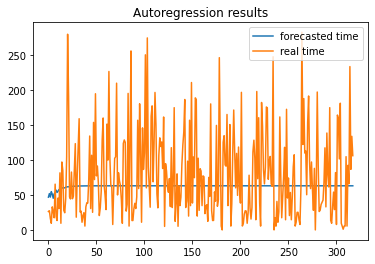

In [190]:
plt.plot(fc[:, 0], label='forecasted time')
plt.plot(X_test['time_passed'].to_numpy(), label='real time')
plt.legend()
plt.title('Autoregression results')
plt.savefig('auto.png')

It looks like autoregression learned a contraction mapping, since the same hoolds for longitude and latitude features. Looks like there is no dependancy that autoregression could catch.

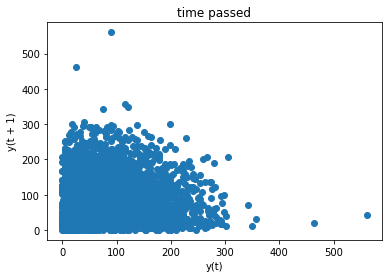

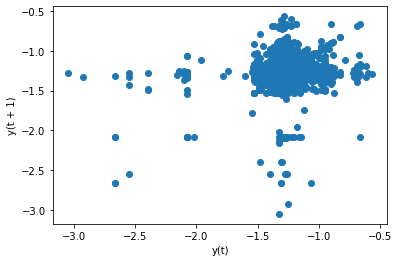

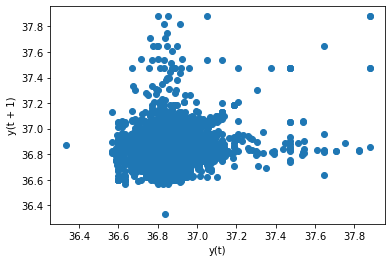

In [191]:
from pandas.plotting import lag_plot

lag_plot(df['time_passed'])
plt.title('time passed')
plt.show()
lag_plot(df['latitude'])
plt.show()
lag_plot(df['longitude'])
plt.show()

Just some blobs of dots, no clear time-dependancy is observed. So it's better to stop trying to predict future crashes treating our data as a time series.

# Predicting the probability of a crash on each of the road segments

Instead, let's try reformulate the task as classification problem. The features are the daily characteristics of weather and some features derived from pca on road segment survey. The target is the number of crashes occured at these particular conditions.

In [195]:
segment_ids = road_surveys['segment_id'].unique()

In [196]:
dates = pd.to_datetime(ss['date'].apply(lambda x: x.date()))
dates = dates.unique()

In [197]:
preprocessed_df = pd.read_csv('Data/preprocessed_df.csv', parse_dates=['datetime'])

In [198]:
preprocessed_df['Date'] = pd.to_datetime(preprocessed_df['datetime'].apply(lambda x: x.date()))
df_with_weather = pd.merge(preprocessed_df, weather, on = 'Date')

In [199]:
df_with_weather = pd.merge(df_with_weather, road_surveys_pca, on='segment_id')
df_with_weather = df_with_weather.drop(['latitude', 'longitude'], axis=1)
df_with_weather = df_with_weather.drop(['datetime'], axis=1)

In [200]:
df_with_weather.head()

,uid,Date,segment_id,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,0,...,140,141,142,143,144,145,146,147,148,149
0,1,2018-01-01,58_1,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914,3.502847,...,0.447656,0.305649,-0.826539,0.700811,-1.139826,-0.20018,0.851227,-0.710364,-0.063724,0.822405
1,5,2018-01-01,58_1,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914,3.502847,...,0.447656,0.305649,-0.826539,0.700811,-1.139826,-0.20018,0.851227,-0.710364,-0.063724,0.822405
2,15,2018-01-02,58_1,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459,3.502847,...,0.447656,0.305649,-0.826539,0.700811,-1.139826,-0.20018,0.851227,-0.710364,-0.063724,0.822405
3,238,2018-01-14,58_1,23.400000,71.400002,0.008620,13.847192,-1.326643,-1.211985,3.502847,...,0.447656,0.305649,-0.826539,0.700811,-1.139826,-0.20018,0.851227,-0.710364,-0.063724,0.822405
4,470,2018-02-03,58_1,15.246802,79.900345,0.009451,13.523859,-2.091435,-2.063789,3.502847,...,0.447656,0.305649,-0.826539,0.700811,-1.139826,-0.20018,0.851227,-0.710364,-0.063724,0.822405


In the following cells we will collect the dataset that will be used in the classification. Some of the cells are commented because it takes some time to compute, but the data is stored in the file already.

In [201]:
def num_crashes(df, date, segment_id):
    return df[(df.Date == date) & (df.segment_id == segment_id)].shape[0]

In [202]:
import itertools
from numpy.random import permutation

day_road_pairs = list(itertools.product(df_with_weather.Date.unique(), segment_ids))
np.random.seed(43)
day_road_pairs = permutation(day_road_pairs)

In [112]:
from tqdm.notebook import tqdm

# we want to ensure that there will approximately equal number of examples
# when crash occured and didn't occur
#MAX_CRASH, MAX_NON_CRASH = 50, 10
#train_pairs = []

#for segment in tqdm(segment_ids):
#    dates = permutation(df_with_weather.Date.unique())
#    crash, non_crash = 0, 0
#    
#    for date in dates:
#        if crash < MAX_CRASH and num_crashes(df_with_weather, date, segment):
#            train_pairs.append([date, segment])
#            crash += 1
#        if non_crash < MAX_NON_CRASH and not num_crashes(df_with_weather, date, segment):
#            train_pairs.append([date, segment])
#            non_crash += 1

In [113]:
#train_pairs = permutation(train_pairs)
#len(train_pairs)

11789

In [114]:
def get_data(iter_pairs):
    
    X = pd.DataFrame(columns=df_with_weather.columns)
    y_arr = []

    for [date, segment_id] in tqdm(iter_pairs):
        y = num_crashes(df_with_weather, date, segment_id)
        y_arr.append(y)
        if y != 0:
            indices = df_with_weather[(df_with_weather.Date == date) 
                            & (df_with_weather.segment_id == segment_id)].index
            index = permutation(indices)[0]
            x_new = df_with_weather[df_with_weather.index == index]
            X = pd.concat([X, x_new], axis=0)
        else:
            x_new = pd.DataFrame(columns=df_with_weather.columns)
            x_new[weather.columns] = weather[weather.Date == date]
            rs_columns = road_surveys_pca.columns
            index = road_surveys_pca[road_surveys_pca.segment_id == segment_id].index[0]
            features = road_surveys_pca[road_surveys_pca.index == index]
            x_new[rs_columns] = features.values
            X = pd.concat([X, x_new], axis=0)
            
    X['num_crashes'] = y_arr
    
    return X

In [115]:
#data = get_data(train_pairs)

In [116]:
#data.to_csv('training_data.csv')

In [117]:
data = pd.read_csv('training_data.csv')

In [77]:
from sklearn.model_selection import train_test_split

N = 10000

data = data.drop(['uid', 'Date', 'segment_id'], axis=1)
data = data.dropna()

X = data.drop(['num_crashes'], axis=1)
y = data['num_crashes'].apply(lambda x: x if x < 10 else 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=36)

# Logistic Regression classification

In [253]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


scaler = StandardScaler()
clf = LogisticRegression(class_weight='balanced')
pipe = Pipeline(steps=[('scaler', scaler), ('classifier', clf)])
param_grid = {'classifier__C': np.logspace(-2, 3, 6),
             'classifier__penalty': ['l1', 'l2']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)

y_pred = search.best_estimator_.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, y_pred))

/home/adalnhard/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy score:  0.38107416879795397


/home/adalnhard/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [254]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[378, 127, 103,  89,  46,  19,  11,   5,   3,   1,  11],
       [ 65,  61,  39,  42,  25,  25,  12,   9,   7,   1,  20],
       [  8,   7,   4,   6,   4,   3,   2,   6,   3,   0,   6],
       [  0,   0,   1,   2,   1,   3,   1,   0,   1,   0,   2],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   1,   1,   0,   1,   0,   0,   0,   0],
       [  0,   0,   1,   1,   0,   0,   2,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   2,   0,   0,   0,   0,   1,   0,   0]])

In [255]:
log_reg_clf = search.best_estimator_

# Random Forest classification

In [256]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(class_weight='balanced', random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy score: ', accuracy_score(y_test, y_pred))

Accuracy score:  0.7041773231031543


In [257]:
confusion_matrix(y_test, y_pred)

array([[683, 102,   7,   1,   0,   0,   0,   0,   0,   0],
       [161, 142,   3,   0,   0,   0,   0,   0,   0,   0],
       [ 23,  25,   1,   0,   0,   0,   0,   0,   0,   0],
       [  3,   8,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   0,   0,   1,   0,   0,   0,   0,   0],
       [  1,   3,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   1,   0,   0,   0,   0,   0,   0,   0]])

The score and confusion matrix are amazing. Let's make gridsearch and see if we can do even better.

In [259]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid = {'n_estimators': [50, 100, 150, 200, 250],
              'max_depth': np.arange(2, 15)}
search = GridSearchCV(clf, param_grid, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 65 candidates, totalling 325 fits


/home/adalnhard/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 325 out of 325 | elapsed:  8.6min finished


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': [50, 100, 150, 200, 250]},
             verbose=1)

In [260]:
randf_clf = search.best_estimator_

In [261]:
search.best_params_

{'max_depth': 14, 'n_estimators': 200}

In [268]:
from sklearn.metrics import f1_score

y_pred = search.best_estimator_.predict(X_test)

# in f1 score we take 'micro' because 'macro' doesn't take into
# account label imbalance, wich is our case
print('Best f1 score: ', f1_score(y_test, y_pred, average='micro'))

Best f1 score:  0.7007672634271099


# Blending models

Looking at confusion matrices for both models, I suggested that blending the outputs of these models whould give better performance.

In [264]:
def predict(X_test, model1=log_reg_clf, model2=randf_clf, p=0.5):
    y_prob1 = model1.predict_proba(X_test)
    y_prob2 = model2.predict_proba(X_test)
    y_prob = y_prob1 * p + y_prob2 * (1 - p)
    
    return y_prob, y_prob.argmax(axis=1)

In [269]:
f1_scores = []

for p in np.linspace(0, 1, 20):
    _, y_pred = predict(X_test, p=p)
    f1_scores.append(f1_score(y_test, y_pred, average='micro'))
    
f1_ = np.array(f1_scores)
print('p = ', np.linspace(0, 1, 20)[np.argmax(f1_)], ', score =', max(f1_scores))

p =  0.0 , score = 0.7007672634271099


In [270]:
y_prob, y_pred = predict(X_test)
print('Best Accuracy score: ', accuracy_score(y_test, y_pred))
print('Best f1 score: ', f1_score(y_test, y_pred, average='micro'))

Best Accuracy score:  0.5797101449275363
Best f1 score:  0.5797101449275363


In [156]:
y_score, _ = predict(X_test)

In [157]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_test.to_numpy().reshape((-1, 1)))
y_true = enc.transform(y_test.to_numpy().reshape((-1, 1))).toarray()

In [158]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

n_classes = np.unique(y_train).shape[0]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [159]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/home/adalnhard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


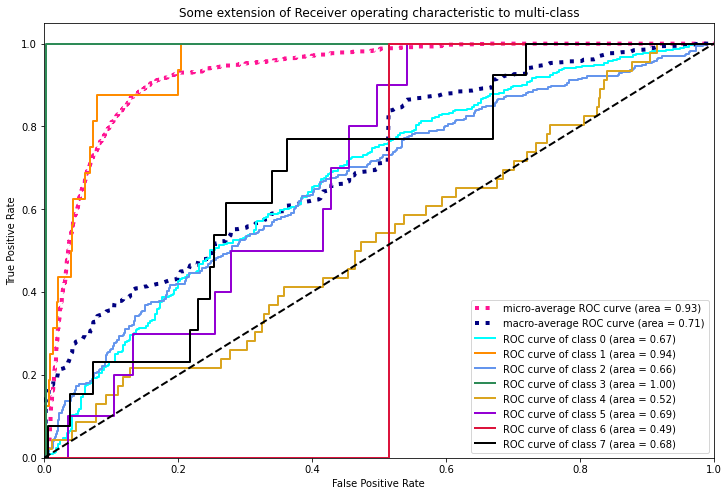

In [160]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'seagreen',
               'goldenrod', 'darkviolet', 'crimson', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Catboost

In [54]:
X_train = X_train.drop('Unnamed: 0', axis=1)
X_test = X_test.drop('Unnamed: 0', axis=1)

In [55]:
import catboost as cbt
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

gb_clf = cbt.CatBoostClassifier(n_estimators=50, verbose=1)
param_grid = {'max_depth': range(3, 6)}
search = GridSearchCV(gb_clf, param_grid, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/adalnhard/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


Learning rate set to 0.5
0:	learn: 1.1130518	total: 88ms	remaining: 4.31s
1:	learn: 0.9251274	total: 128ms	remaining: 3.06s
2:	learn: 0.8857063	total: 175ms	remaining: 2.74s
3:	learn: 0.8573537	total: 228ms	remaining: 2.63s
4:	learn: 0.8409446	total: 296ms	remaining: 2.66s
5:	learn: 0.8300014	total: 338ms	remaining: 2.48s
6:	learn: 0.8216163	total: 382ms	remaining: 2.35s
7:	learn: 0.8142824	total: 436ms	remaining: 2.29s
8:	learn: 0.8093151	total: 508ms	remaining: 2.31s
9:	learn: 0.8051244	total: 558ms	remaining: 2.23s
10:	learn: 0.8001485	total: 601ms	remaining: 2.13s
11:	learn: 0.7963228	total: 649ms	remaining: 2.06s
12:	learn: 0.7903126	total: 715ms	remaining: 2.03s
13:	learn: 0.7856356	total: 762ms	remaining: 1.96s
14:	learn: 0.7824824	total: 811ms	remaining: 1.89s
15:	learn: 0.7788612	total: 860ms	remaining: 1.83s
16:	learn: 0.7745125	total: 925ms	remaining: 1.79s
17:	learn: 0.7709955	total: 978ms	remaining: 1.74s
18:	learn: 0.7667663	total: 1.03s	remaining: 1.69s
19:	learn: 0.7606

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7ffa12d16550>,
             n_jobs=-1, param_grid={'max_depth': range(3, 6)}, verbose=1)

In [56]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_pred = search.best_estimator_.predict(X_test)
f1_score(y_pred, y_test, average='micro')

0.7246376811594203

In [57]:
y_pred = search.best_estimator_.predict(X_train)
f1_score(y_pred, y_train, average='micro')

0.7374455182869054

In [58]:
catboost_clf = search.best_estimator_

In [59]:
search.best_params_

{'max_depth': 3}

# Prediction and clustering

Now we can make predictions of the number of crashes based on a road segment surveys and weather forecast. First, join all these data in an appropriate dataframe for a model. We will generate a new data frame and predict ambulance locations for each day.

In [60]:
from pandas.tseries.offsets import DateOffset

# dates for wich we should predict
dates = pd.to_datetime(ss.date.apply(lambda x: x.date())).unique()

In [61]:
def get_X_new(date):
    X_new = pd.DataFrame()
    X_new[road_surveys_pca.columns] = road_surveys_pca
    X_new.loc[:, 'Date'] = date
    X_new = pd.merge(X_new, weather, on = 'Date')
    w_cols, rs_cols = weather.columns.values, road_surveys_pca.columns.values
    X_new = X_new[np.concatenate([w_cols, rs_cols], axis=0)]
    X_new = X_new.drop(['Date', 'segment_id'], axis=1)
    
    
    return X_new

In [62]:
def to_3hrs_df(date, date_next, centers):
    # assume that ambulance doesn't change position through a day
    col_names = ss.columns
    df_new = pd.DataFrame(columns=col_names)
    time_range = pd.date_range(str(date)[:10], str(date_next)[:10], freq='3h')[:-1]
    df_new['date'] = time_range
    df_new[col_names[1:]] = np.array(centers).reshape(12, 1)[:,0]
    df_new = df_new.append([df_new.iloc]*time_range.shape[0],ignore_index=True)

    
    return df_new

In [63]:
def get_crashes_geometry(crashes, segment_ids=road_surveys_pca['segment_id'].values):
    crash_geom = []
    
    for i, n in enumerate(crashes):
        segm_id = segment_ids[i]
        # add segment center to crash_geom n=num_crash times
        segm_geom = segments_merged[segments_merged.segment_id == segm_id]['geometry'].values[0]
        crash_geom.extend([segm_geom] * n[0])
        
    return crash_geom

In [67]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import euclidean_distance_square
from pyclustering.utils import euclidean_distance
from pyclustering.utils.metric import type_metric, distance_metric

def get_centers(crashes_geom, metric):
    metric = distance_metric(type_metric.USER_DEFINED, func=metric)
    initial_centers = kmeans_plusplus_initializer(crashes_geom, 6).initialize()
    kmeans_instance = kmeans(crashes_geom, initial_centers, metric=metric)
    kmeans_instance.process()
    final_centers = kmeans_instance.get_centers()
    
    return final_centers

Here we try square root from distance in kmeans, since it optimizes the sum of the squares, but our score is the just sum of distances. Also, we calculate statistics of crashes over relatively big period (3 days) because when we predict ambulance positions for each day, we total number of crashes is very small and sample variance too big.

In [68]:
from tqdm.notebook import tqdm

sub = pd.DataFrame(columns=ss.columns)
t = []

for i, date in tqdm(enumerate(dates[:-1])):
        
    X_new = get_X_new(date)
    num_crashes = catboost_clf.predict(X_new)
    t.append(num_crashes)
    if len(t) == 3:
        num_crashes = sum(t)
        crashes_geom =  get_crashes_geometry(num_crashes)
        centers = get_centers(crashes_geom, euclidean_distance)
        centers = np.array(centers)[... ,::-1]
        df_new = to_3hrs_df(dates[i-2], dates[i+1], centers)
        t = []
    
        sub = sub.append(df_new)

In [69]:
next_date = pd.to_datetime(dates[-1]) + pd.tseries.offsets.DateOffset(days=1)
date = dates[-1]

X_new = get_X_new(date)
num_crashes = catboost_clf.predict(X_new)
t.append(num_crashes)
if len(t) == 3:
    num_crashes = sum(t)
    crashes_geom =  get_crashes_geometry(num_crashes)
    centers = get_centers(crashes_geom, euclidean_distance)
    centers = np.array(centers)[... ,::-1]
    df_new = to_3hrs_df(dates[i-2], next_date, centers)
    t = []
    
    sub = sub.append(df_new)

In [70]:
sub.to_csv('submission7.csv', index=False)

In [71]:
sub.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude,0
0,2019-07-01 00:00:00,-1.330853,36.869641,-1.270859,36.740482,-1.243723,36.844444,-1.203078,36.91864,-1.282204,37.02675,-1.302287,36.804888,NaN
1,2019-07-01 03:00:00,-1.330853,36.869641,-1.270859,36.740482,-1.243723,36.844444,-1.203078,36.91864,-1.282204,37.02675,-1.302287,36.804888,NaN
2,2019-07-01 06:00:00,-1.330853,36.869641,-1.270859,36.740482,-1.243723,36.844444,-1.203078,36.91864,-1.282204,37.02675,-1.302287,36.804888,NaN
3,2019-07-01 09:00:00,-1.330853,36.869641,-1.270859,36.740482,-1.243723,36.844444,-1.203078,36.91864,-1.282204,37.02675,-1.302287,36.804888,NaN
4,2019-07-01 12:00:00,-1.330853,36.869641,-1.270859,36.740482,-1.243723,36.844444,-1.203078,36.91864,-1.282204,37.02675,-1.302287,36.804888,NaN


From scores of the submissions are not so good actually: around 52 and 51 for blending model and gradient boosting respectively. The reason may be because of the high class imbalance that's hard to tackle or the models we are using are too simple. The other reason may be in our data preprocessing: maybe a big variance occurs when we replace the location of the crash by the center of the nearest road segment.

Link to presentation: https://www.youtube.com/watch?v=BGf2DY69piM&feature=youtu.be